In [1]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

env = gym.make('Asterix-v0').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


print(env.action_space)
print(env.observation_space)
print(device)


import warnings
warnings.filterwarnings('ignore')

#Code is inspired from Pytorch tutorial

Discrete(9)
Box(210, 160, 3)
cuda


<h3>Preprocess frames</h3>

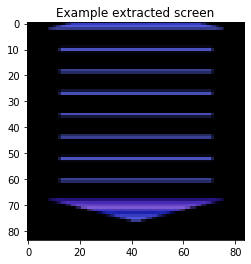

torch.Size([1, 3, 84, 84])


In [2]:
resize = T.Compose([T.ToPILImage(), T.Resize(84, interpolation=Image.CUBIC), T.ToTensor()])

# This is based on the code from gym.
screen_width = 600

def get_screen():
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    screen = screen[:, 20:180]
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    return resize(screen).unsqueeze(0).to(device)

env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

print(get_screen().shape)

<h3>Experience Replay Buffer </h3>

In [3]:
# Transisition tuple to store
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

<h3>Dueling Network</h3>

In [4]:
class Dueling_Network(nn.Module):

    def __init__(self, h, w, outputs):
        super(Dueling_Network, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(128)
        
        def conv2d_size_out(size, kernel_size = 4, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w, 5, 2), 5, 2), 5, 2)
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h, 5, 2), 5, 2), 5, 2)
        
#         self.head = nn.Linear(convw * convh * 64, 128)
#         self.value = nn.Linear(128, outputs)
        
        self.value_stream = nn.Sequential(
            nn.Linear(convw * convh * 128, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )
        
        self.advantage_stream = nn.Sequential(
            nn.Linear(convw * convh * 128, 512),
            nn.ReLU(),
            nn.Linear(512, outputs)
        )
        


    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)
        values = self.value_stream(x)
        advantages = self.advantage_stream(x)
        return values + (advantages - advantages.mean())
    

<h3>Hyperparameters and Initialisation</h3>

In [5]:
BATCH_SIZE = 32
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 2000
TARGET_UPDATE = 9

init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape


policy_net = Dueling_Network(screen_height, screen_width, env.action_space.n).to(device)
target_net = Dueling_Network(screen_height, screen_width, env.action_space.n).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=0.0001)
memory = ReplayMemory(10000)


steps_done = 0
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
#     print(eps_threshold)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(env.action_space.n)]], device=device, dtype=torch.long)




<h3>Model update function </h3>
<p>Update function DDQN</p>

In [6]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    
    #DQN function to evaluate the target network
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

<h3>Training</h3>

In [ ]:
num_episodes = 4000
total_rewards= []
for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    r = 0
    for t in count():
        action = select_action(state)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        memory.push(state, action, next_state, reward)

        state = next_state
        
        optimize_model()
        r += reward.item()
        if done:
            break
            

    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
    
    print("Episode : "+ str(i_episode), "Reward: "+str(r))
    total_rewards.append(r)


Episode : 0 Reward: 150.0
Episode : 1 Reward: 200.0
Episode : 2 Reward: 250.0
Episode : 3 Reward: 550.0
Episode : 4 Reward: 300.0
Episode : 5 Reward: 150.0
Episode : 6 Reward: 200.0
Episode : 7 Reward: 400.0
Episode : 8 Reward: 600.0
Episode : 9 Reward: 600.0
Episode : 10 Reward: 350.0
Episode : 11 Reward: 100.0
Episode : 12 Reward: 450.0
Episode : 13 Reward: 100.0
Episode : 14 Reward: 200.0
Episode : 15 Reward: 200.0
Episode : 16 Reward: 300.0
Episode : 17 Reward: 350.0
Episode : 18 Reward: 400.0
Episode : 19 Reward: 500.0
Episode : 20 Reward: 350.0
Episode : 21 Reward: 100.0
Episode : 22 Reward: 250.0
Episode : 23 Reward: 100.0
Episode : 24 Reward: 200.0
Episode : 25 Reward: 250.0
Episode : 26 Reward: 450.0
Episode : 27 Reward: 350.0
Episode : 28 Reward: 100.0
Episode : 29 Reward: 200.0
Episode : 30 Reward: 200.0
Episode : 31 Reward: 300.0
Episode : 32 Reward: 150.0
Episode : 33 Reward: 150.0
Episode : 34 Reward: 150.0
Episode : 35 Reward: 100.0
Episode : 36 Reward: 300.0
Episode : 3

Episode : 297 Reward: 600.0
Episode : 298 Reward: 800.0
Episode : 299 Reward: 200.0
Episode : 300 Reward: 150.0
Episode : 301 Reward: 750.0
Episode : 302 Reward: 150.0
Episode : 303 Reward: 700.0
Episode : 304 Reward: 150.0
Episode : 305 Reward: 150.0
Episode : 306 Reward: 550.0
Episode : 307 Reward: 100.0
Episode : 308 Reward: 100.0
Episode : 309 Reward: 300.0
Episode : 310 Reward: 250.0
Episode : 311 Reward: 350.0
Episode : 312 Reward: 150.0
Episode : 313 Reward: 150.0
Episode : 314 Reward: 150.0
Episode : 315 Reward: 700.0
Episode : 316 Reward: 600.0
Episode : 317 Reward: 500.0
Episode : 318 Reward: 300.0
Episode : 319 Reward: 700.0
Episode : 320 Reward: 250.0
Episode : 321 Reward: 100.0
Episode : 322 Reward: 700.0
Episode : 323 Reward: 750.0
Episode : 324 Reward: 600.0
Episode : 325 Reward: 500.0
Episode : 326 Reward: 100.0
Episode : 327 Reward: 700.0
Episode : 328 Reward: 550.0
Episode : 329 Reward: 650.0
Episode : 330 Reward: 150.0
Episode : 331 Reward: 500.0
Episode : 332 Reward

Episode : 590 Reward: 650.0
Episode : 591 Reward: 650.0
Episode : 592 Reward: 500.0
Episode : 593 Reward: 700.0
Episode : 594 Reward: 100.0
Episode : 595 Reward: 600.0
Episode : 596 Reward: 100.0
Episode : 597 Reward: 550.0
Episode : 598 Reward: 100.0
Episode : 599 Reward: 600.0
Episode : 600 Reward: 150.0
Episode : 601 Reward: 600.0
Episode : 602 Reward: 400.0
Episode : 603 Reward: 900.0
Episode : 604 Reward: 550.0
Episode : 605 Reward: 750.0
Episode : 606 Reward: 400.0
Episode : 607 Reward: 600.0
Episode : 608 Reward: 650.0
Episode : 609 Reward: 350.0
Episode : 610 Reward: 600.0
Episode : 611 Reward: 800.0
Episode : 612 Reward: 650.0
Episode : 613 Reward: 100.0
Episode : 614 Reward: 100.0
Episode : 615 Reward: 850.0
Episode : 616 Reward: 150.0
Episode : 617 Reward: 150.0
Episode : 618 Reward: 350.0
Episode : 619 Reward: 650.0
Episode : 620 Reward: 100.0
Episode : 621 Reward: 700.0
Episode : 622 Reward: 450.0
Episode : 623 Reward: 750.0
Episode : 624 Reward: 550.0
Episode : 625 Reward

In [ ]:
print('Complete')
env.render()
env.close()
plt.ioff()
plt.show()

window = 1
plt.xlabel('Episode')
plt.ylabel('Total Rewards')
plt.plot([np.mean(total_rewards[tr:tr+window]) for tr in range(window, len(total_rewards))])

In [ ]:
print(np.mean(total_rewards))
print(np.count_nonzero(np.array(total_rewards) > 100))
plt.plot([np.mean(total_rewards[tr:tr+100]) for tr in range(window, len(total_rewards))])